In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import sys, os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
#!pip install torch-geometric
from torch_geometric.data import Data, DataLoader


In [ ]:
# Read the CSV file
data_path = '/content/drive/MyDrive/creditcard/creditcard.csv'
data = pd.read_csv(data_path)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Normalize Amount
data['normAmount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1,1))
data['normTime'] = StandardScaler().fit_transform(np.array(data['Time']).reshape(-1,1))

# Now dropping Time and Amount as they'll be irrelevant for our prediction
data = data.drop(['Amount', 'Time'], axis = 1)

In [ ]:
# Assuming you have already converted your data into a graph format

# Define node features (excluding 'Class' column)
features = data.drop(columns=['Class']).values

# Define the class labels (target)
class_labels = data['Class'].values

# Define a placeholder edge_index (no actual edges)
edges = torch.tensor([[], []], dtype=torch.long)

# Create a PyTorch Geometric Data object
#data = Data(x=torch.Tensor(features),
#            y=torch.Tensor(class_labels).long())
data = Data(x=torch.Tensor(features),
            y=torch.Tensor(class_labels).long(),
            edge_index=edges
            )

# Now 'data' contains the necessary information to represent your data as a graph


In [ ]:
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Assuming num_features is the number of input features (excluding the 'Class' column)
# hidden_dim is the dimension of the hidden layer, and output_dim is the number of classes

num_features = 30  # Assuming 30 features based on your dataset
hidden_dim = 64   # Adjust as needed
output_dim = 2    # Assuming binary classification (fraud or not fraud)
learning_rate = 0.001

# Create an instance of the GNN model
gnn_model = GNNModel(num_features, hidden_dim, output_dim)

# Print the model architecture
print(gnn_model)


GNNModel(
  (conv1): GCNConv(30, 64)
  (conv2): GCNConv(64, 2)
)


In [ ]:
# Create DataLoader
loader = DataLoader([data], batch_size=1, shuffle=True)

# Define loss function (assuming binary cross entropy)
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=learning_rate)

# Define evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for data in loader:
            output = model(data)
            target = data.y
            total_loss += criterion(output, target).item()

            # Compute accuracy
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

            # Compute true positives, false positives, false negatives
            true_positives += ((pred == 1) & (target == 1)).sum().item()
            false_positives += ((pred == 1) & (target == 0)).sum().item()
            false_negatives += ((pred == 0) & (target == 1)).sum().item()

            total_samples += len(data.y)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total_samples

    # Compute precision, recall, and F1-score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return avg_loss, accuracy, precision, recall, f1_score


# Training loop
num_epochs = 10
# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        output = gnn_model(data)
        target = data.y
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    # After each epoch, compute validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate(gnn_model, loader, criterion)

    # Append metrics to lists
    train_losses.append(avg_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)

    print(f'Epoch {epoch+1}, Avg. Loss: {avg_loss:.4f}, Val. Loss: {val_loss:.4f}, Val. Acc: {val_accuracy:.4f}, Val. Precision: {val_precision:.4f}, Val. Recall: {val_recall:.4f}, Val. F1 Score: {val_f1_score:.4f}')


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Avg. Loss: 0.2361, Val. Loss: 0.2226, Val. Acc: 0.9899, Val. Precision: 0.0174, Val. Recall: 0.0874, Val. F1 Score: 0.0290
Epoch 2, Avg. Loss: 0.2226, Val. Loss: 0.2099, Val. Acc: 0.9927, Val. Precision: 0.0199, Val. Recall: 0.0671, Val. F1 Score: 0.0307
Epoch 3, Avg. Loss: 0.2099, Val. Loss: 0.1978, Val. Acc: 0.9947, Val. Precision: 0.0275, Val. Recall: 0.0610, Val. F1 Score: 0.0379
Epoch 4, Avg. Loss: 0.1978, Val. Loss: 0.1865, Val. Acc: 0.9960, Val. Precision: 0.0352, Val. Recall: 0.0508, Val. F1 Score: 0.0416
Epoch 5, Avg. Loss: 0.1865, Val. Loss: 0.1758, Val. Acc: 0.9968, Val. Precision: 0.0500, Val. Recall: 0.0488, Val. F1 Score: 0.0494
Epoch 6, Avg. Loss: 0.1758, Val. Loss: 0.1658, Val. Acc: 0.9974, Val. Precision: 0.0712, Val. Recall: 0.0427, Val. F1 Score: 0.0534
Epoch 7, Avg. Loss: 0.1658, Val. Loss: 0.1565, Val. Acc: 0.9978, Val. Precision: 0.1159, Val. Recall: 0.0386, Val. F1 Score: 0.0579
Epoch 8, Avg. Loss: 0.1565, Val. Loss: 0.1477, Val. Acc: 0.9980, Val. Precis

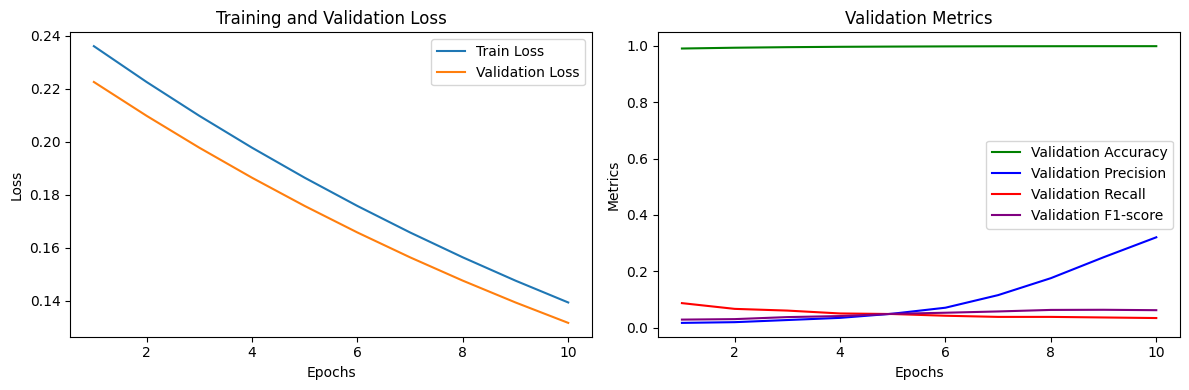

In [ ]:

# Plot the metrics
epochs = range(1, num_epochs+1)

# Plot Losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy, Precision, Recall, F1-score
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision', color='blue')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall', color='red')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1-score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Metrics')
plt.legend()

plt.tight_layout()
plt.show()
